In [1]:
"""
INSY 662 - Individual Project
Kickstarter Success Prediction and Clustering Analysis

Author: Matthieu Lafont
Date: 12/06/2025
"""

'\nINSY 662 - Individual Project\nKickstarter Success Prediction and Clustering Analysis\n\nAuthor: Matthieu Lafont\nDate: 12/06/2025\n'

In [2]:
# Import libraries
import joblib
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load all CSV files from folder
import glob
import os

data_folder = r'Kickstarter_2025-09-11T03_20_29_905Z'
csv_files = glob.glob(os.path.join(data_folder, 'Kickstarter*.csv'))

df_list = []
for file in csv_files:
    df_temp = pd.read_csv(file)
    df_list.append(df_temp)

df = pd.concat(df_list, ignore_index=True)

# Remove duplicates
if 'id' in df.columns:
    df = df.drop_duplicates(subset=['id'], keep='first')

print(f"Loaded {len(df)} campaigns")

Loaded 205530 campaigns


In [4]:
# Check data
print(df.head())
print(df.shape)
print(df['state'].value_counts())

   backers_count                                              blurb  \
0             62  Forbear! is a new theatre company aiming to pr...   
1              2     Bridging Quantum Computing and ASIC Technology   
2              0  Looking to set up a pole dance, yoga and aeria...   
3             45  A clumsy boy who cannot ride a bike without tr...   
4             80  Catchy pop songs about your everyday life, by ...   

                                            category  \
0  {"id":284,"name":"Musical","analytics_name":"M...   
1  {"id":51,"name":"Software","analytics_name":"S...   
2  {"id":255,"name":"Residencies","analytics_name...   
3  {"id":29,"name":"Animation","analytics_name":"...   
4  {"id":42,"name":"Pop","analytics_name":"Pop","...   

   converted_pledged_amount country country_displayable_name  created_at  \
0                   15376.0      GB       the United Kingdom  1428084500   
1                       2.0      US        the United States  1708550474   
2       

In [5]:
print(df.columns)

Index(['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'country_displayable_name', 'created_at', 'creator',
       'currency', 'currency_symbol', 'currency_trailing_code',
       'current_currency', 'deadline', 'disable_communication', 'fx_rate',
       'goal', 'id', 'is_disliked', 'is_in_post_campaign_pledging_phase',
       'is_launched', 'is_liked', 'is_starrable', 'launched_at', 'location',
       'name', 'percent_funded', 'photo', 'pledged', 'prelaunch_activated',
       'profile', 'slug', 'source_url', 'spotlight', 'staff_pick', 'state',
       'state_changed_at', 'static_usd_rate', 'urls', 'usd_exchange_rate',
       'usd_pledged', 'usd_type', 'video'],
      dtype='object')


In [6]:
# Filter to successful and failed only
df = df[df['state'].isin(['successful', 'failed'])].copy()
print(f"After filtering: {len(df)} campaigns")

After filtering: 185949 campaigns


In [7]:
# Check for missing values and create clean base dataframe
print("Missing values check:")
print(f"Total campaigns: {len(df)}")

key_columns = ['name', 'blurb', 'goal', 'country', 'currency', 'category',
               'deadline', 'launched_at', 'created_at', 'video', 'staff_pick', 'state']

missing_counts = df[key_columns].isnull().sum()
missing_pcts = (df[key_columns].isnull().sum() / len(df)) * 100

print("\nMissing values by column:")
for col in key_columns:
    if missing_counts[col] > 0:
        print(f"{col}: {missing_counts[col]} ({missing_pcts[col]:.2f}%)")

total_missing_rows = df[key_columns].isnull().any(axis=1).sum()
missing_pct_total = (total_missing_rows / len(df)) * 100

# Keep only the key columns in the base dataframe
df = df[key_columns].copy()
print(f"\nBase dataframe now contains only {len(key_columns)} key columns")
print(f"Shape: {df.shape}")

Missing values check:
Total campaigns: 185949

Missing values by column:
blurb: 3 (0.00%)
video: 60988 (32.80%)

Base dataframe now contains only 12 key columns
Shape: (185949, 12)


In [8]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [9]:
df = df.dropna(subset=['blurb'])
len(df)

185946

In [10]:
# Feature engineering
# Text features

df['blurb_len'] = df['blurb'].str.len()

# Extract category from JSON


def get_category(cat_json):
    try:
        cat_dict = json.loads(cat_json.replace("'", '"'))
        return cat_dict.get('name', 'Unknown')
    except:
        return 'Unknown'


df['category_name'] = df['category'].apply(get_category)

# Time features
df['created_at'] = pd.to_datetime(df['created_at'], unit='s', errors='coerce')
df['deadline'] = pd.to_datetime(df['deadline'], unit='s', errors='coerce')
df['launched_at'] = pd.to_datetime(
    df['launched_at'], unit='s', errors='coerce')

df['campaign_days'] = (df['deadline'] - df['launched_at']).dt.days
df['prep_days'] = (df['launched_at'] - df['created_at']).dt.days
df['launch_month'] = df['launched_at'].dt.month
df['launch_year'] = df['launched_at'].dt.year

# Goal features
df['goal'] = pd.to_numeric(df['goal'], errors='coerce')
df['log_goal'] = np.log(df['goal'] + 1)

# Media and staff features
df['has_video'] = df['video'].notnull().astype(int)
df['staff_pick'] = df['staff_pick'].astype(int)

In [11]:
# Extract category details from JSON and create separate dataframe
def parse_category(cat_json):
    """Parse category JSON and extract all fields except id, position, color, url"""
    try:
        cat_dict = json.loads(cat_json.replace("'", '"'))
        # Remove unwanted fields
        fields_to_remove = ['name', 'slug', 'id',
                            'position', 'color', 'urls', 'parent_id']
        for field in fields_to_remove:
            cat_dict.pop(field, None)
        return cat_dict
    except:
        return {}


# Create list to store category data
category_data = []

for idx, row in df.iterrows():
    cat_info = parse_category(row['category'])
    cat_info['index'] = idx  # Keep the original index
    category_data.append(cat_info)

# Create category dataframe
df_category = pd.DataFrame(category_data)
df_category.set_index('index', inplace=True)

print(f"Category dataframe shape: {df_category.shape}")
print(f"\nCategory columns: {df_category.columns.tolist()}")
print(f"\nFirst few rows:")
print(df_category.head())
print(f"\nSample category info:")
print(df_category.iloc[0])

# Merge with main dataframe
df = df.merge(df_category, left_index=True, right_index=True, how='left')
print(f"\nMain dataframe shape after merge: {df.shape}")
print(f"New columns added: {df_category.columns.tolist()}")

Category dataframe shape: (185946, 2)

Category columns: ['analytics_name', 'parent_name']

First few rows:
      analytics_name   parent_name
index                             
0            Musical       Theater
1           Software    Technology
2        Residencies         Dance
3          Animation  Film & Video
4                Pop         Music

Sample category info:
analytics_name    Musical
parent_name       Theater
Name: 0, dtype: object

Main dataframe shape after merge: (185946, 22)
New columns added: ['analytics_name', 'parent_name']


In [12]:
# Feature verification
print(df['has_video'].value_counts())
print(df['staff_pick'].value_counts())

has_video
1    124961
0     60985
Name: count, dtype: int64
staff_pick
0    156739
1     29207
Name: count, dtype: int64


# ----------------**CLASSIFICATION**-----------------


In [13]:
# Feature Engineering for Classification
df_class = df.copy()

categorical_features = ['country', 'currency', 'parent_name', 'analytics_name']
numerical_features = ['blurb_len', 'goal', 'log_goal', 'campaign_days',
                      'launch_month', 'launch_year', 'has_video', 'prep_days']

# Remove rows with NaN in numerical features
df_class = df_class.dropna(subset=numerical_features)
print(f"Rows after removing NaN: {len(df_class)}")
df_class_features = df_class[numerical_features + categorical_features].copy()
# One-hot encode
X = pd.get_dummies(df_class[numerical_features + categorical_features],
                   columns=categorical_features, drop_first=True)
y = (df_class['state'] == 'successful').astype(int)

print(f"Total features: {X.shape[1]}")
print(y.value_counts())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Rows after removing NaN: 185946
Total features: 218
state
1    115419
0     70527
Name: count, dtype: int64
Train: (148756, 218), Test: (37190, 218)


In [14]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
# RandomizedSearchCV for Random Forest (using sample for speed)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Sample 15,000 rows for faster training
np.random.seed(42)
sample_idx = np.random.choice(len(X_train_scaled), size=15000, replace=False)
X_train_sample = X_train_scaled[sample_idx]
y_train_sample = y_train.iloc[sample_idx]

rf_parameters = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [3, 5, 10],
    'min_samples_leaf': [2, 3, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

rf_randomsearch = RandomizedSearchCV(RandomForestClassifier(
    random_state=42), rf_parameters, n_iter=100, cv=4, n_jobs=-1, random_state=42)
rf_randomsearch.fit(X_train_sample, y_train_sample)

print("Best parameters:", rf_randomsearch.best_params_)
print("Best CV Score:", rf_randomsearch.best_score_)

Best parameters: {'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}
Best CV Score: 0.7868666666666667


In [16]:
# Evaluate Random Forest on full test set
rf_best_model = rf_randomsearch.best_estimator_
print("Random Forest:")
print("Train accuracy (sample):", rf_best_model.score(
    X_train_sample, y_train_sample))
print("Test accuracy:", rf_best_model.score(X_test_scaled, y_test))
confusion_matrix(y_test, rf_best_model.predict(X_test_scaled))

Random Forest:
Train accuracy (sample): 0.8638
Test accuracy: 0.79005108900242


array([[ 8474,  5632],
       [ 2176, 20908]])

In [17]:
from sklearn.metrics import precision_score, f1_score
y_test_pred = rf_best_model.predict(X_test_scaled)
print(f'Precision : {precision_score(y_test, y_test_pred)}')
print(f'F1-Score : {f1_score(y_test, y_test_pred)}')

Precision : 0.787792012057272
F1-Score : 0.8426567789779139


# ----------------**CLUSTERING**-----------------


In [18]:
# Feature Engineering for Clustering
df_cluster = df.copy()

In [19]:
numerical_features = ['goal', 'campaign_days',
                      'prep_days', 'has_video', 'blurb_len']


# Combine
X_cluster = pd.concat([df_cluster[numerical_features],],
                      axis=1)


# Scale
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

In [20]:
# Sample 10,000 rows for clustering
np.random.seed(42)
cluster_sample_idx = np.random.choice(
    len(X_cluster_scaled), size=55000, replace=False)
X_cluster_sample = X_cluster_scaled[cluster_sample_idx]

Testing K-Means with k from 2 to 15


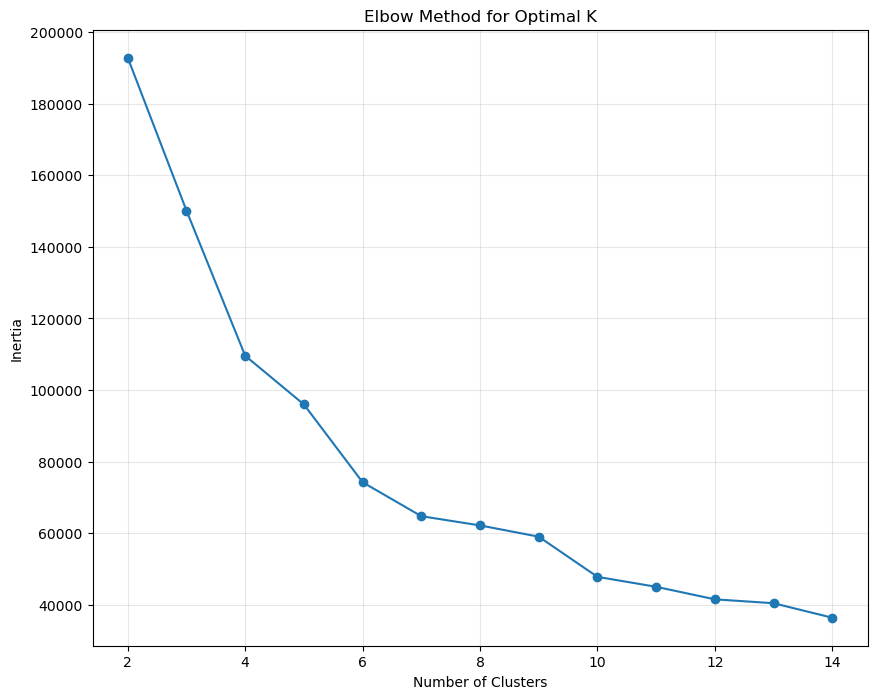

In [21]:
# Elbow Method for Optimal K
from sklearn.cluster import KMeans

print("Testing K-Means with k from 2 to 15")

inertia_values = []
K = range(2, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_cluster_sample)  # Changed from X_pca
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(10, 8))
plt.plot(K, inertia_values, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.grid(alpha=0.3)
plt.show()

Testing silhouette scores for k from 2 to 5
k=2: silhouette score = 0.6381
k=3: silhouette score = 0.3047
k=4: silhouette score = 0.4122
k=5: silhouette score = 0.3934


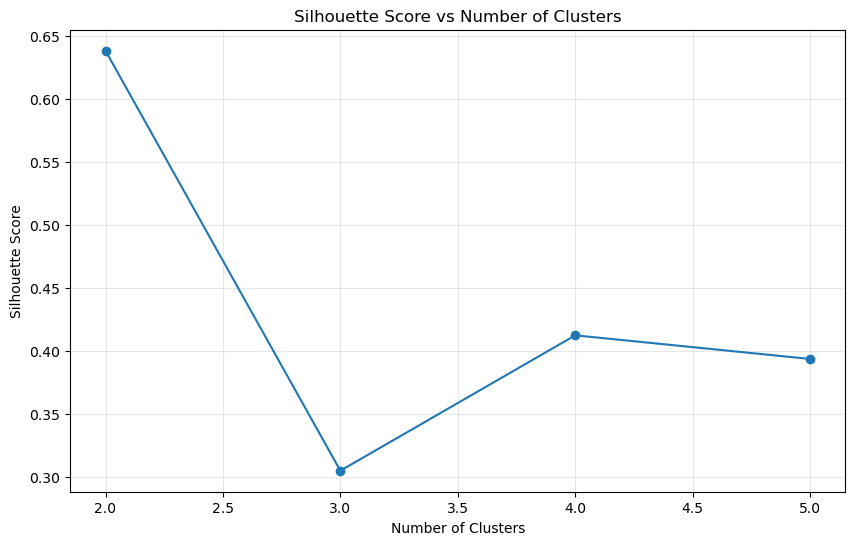

In [22]:
# Silhouette Score Analysis
from sklearn.metrics import silhouette_score

print("Testing silhouette scores for k from 2 to 5")

silhouette_scores = []
K = range(2, 6)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_cluster_sample)
    score = silhouette_score(X_cluster_sample, labels)
    silhouette_scores.append(score)
    print(f"k={k}: silhouette score = {score:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters")
plt.grid(alpha=0.3)
plt.show()

In [23]:
# Fit K-Means with Optimal K
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
kmeans.fit(X_cluster_sample)  # Changed from X_pca
cluster_labels = kmeans.labels_

# Add cluster labels to dataframe
df_cluster_sample = df_cluster.iloc[cluster_sample_idx].copy()
df_cluster_sample['cluster'] = cluster_labels

print(f"Final K-Means model with k={optimal_k}")
print("Cluster sizes:")
print(pd.Series(cluster_labels).value_counts().sort_index())

Final K-Means model with k=4
Cluster sizes:
0      761
1    31285
2     8209
3    14745
Name: count, dtype: int64


In [ ]:
# Cluster Analysis
for cluster_id in range(optimal_k):
    cluster_data = df_cluster_sample[df_cluster_sample['cluster'] == cluster_id]

    # Cluster size
    cluster_size = len(cluster_data)

    # Success rate
    success_rate = (cluster_data['state'] == 'successful').mean() * 100

    # Average metrics for the 5 numerical features
    avg_goal = cluster_data['goal'].mean()
    avg_campaign_days = cluster_data['campaign_days'].mean()
    avg_prep_days = cluster_data['prep_days'].mean()
    avg_has_video = cluster_data['has_video'].mean() * 100  # As percentage
    avg_blurb_len = cluster_data['blurb_len'].mean()

    # Top 3 categories (if parent_name exists in df_cluster_sample)
    if 'parent_name' in cluster_data.columns:
        top_categories = cluster_data['parent_name'].value_counts().head(
            3).index.tolist()
        top_cats_str = ', '.join(top_categories)
    else:
        top_cats_str = 'N/A'

    print(f"Cluster {cluster_id} (n={cluster_size}):")
    print(f"  Success rate: {success_rate:.2f}%")
    print(f"  Avg goal: ${avg_goal:,.2f}")
    print(f"  Avg campaign days: {avg_campaign_days:.2f}")
    print(f"  Avg prep days: {avg_prep_days:.2f}")
    print(f"  Has video: {avg_has_video:.2f}%")
    print(f"  Top categories: {top_cats_str}")
    print(f"  Blurb_len : {avg_blurb_len:.2f}%")
    print()

Cluster 0 (n=761):
  Success rate: 61.76%
  Avg goal: $35,799.45
  Avg campaign days: 34.77
  Avg prep days: 1060.03
  Has video: 81.73%
  Top categories: Music, Film & Video, Technology
  Staff pick: 10537.45%

Cluster 1 (n=31285):
  Success rate: 71.76%
  Avg goal: $32,038.97
  Avg campaign days: 29.22
  Avg prep days: 47.36
  Has video: 100.00%
  Top categories: Film & Video, Music, Technology
  Staff pick: 10783.74%

Cluster 2 (n=8209):
  Success rate: 40.39%
  Avg goal: $144,295.32
  Avg campaign days: 57.83
  Avg prep days: 34.27
  Has video: 59.93%
  Top categories: Film & Video, Music, Technology
  Staff pick: 10127.57%

Cluster 3 (n=14745):
  Success rate: 53.10%
  Avg goal: $29,440.69
  Avg campaign days: 27.39
  Avg prep days: 26.22
  Has video: 0.00%
  Top categories: Art, Publishing, Games
  Staff pick: 10044.42%



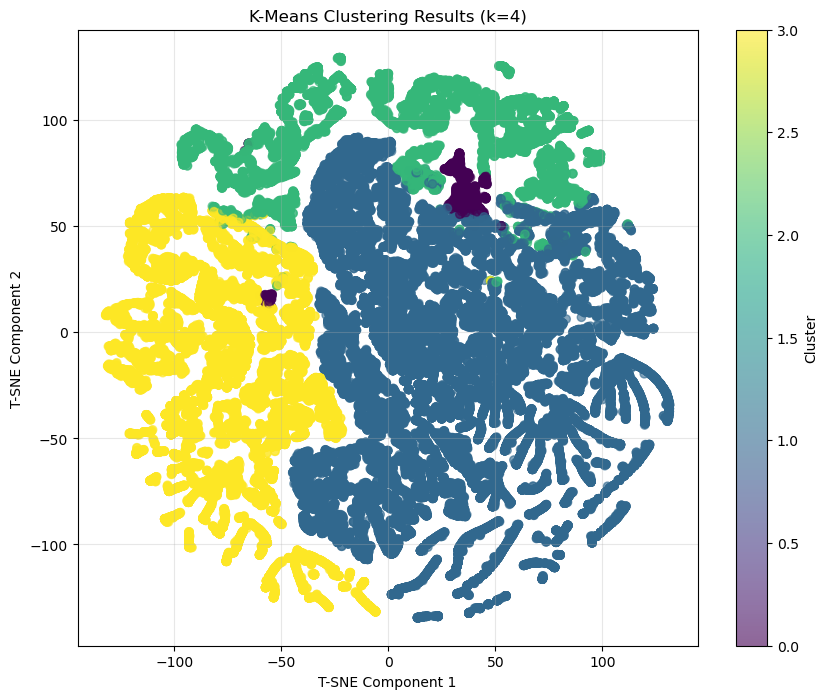

In [25]:
# 2D Visualization with T-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_cluster_sample)

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels,
            cmap='viridis', alpha=0.6)
plt.xlabel('T-SNE Component 1')
plt.ylabel('T-SNE Component 2')
plt.title(f'K-Means Clustering Results (k={optimal_k})')
plt.colorbar(label='Cluster')
plt.grid(alpha=0.3)
plt.show()

In [26]:
# Save model and preprocessing objects
joblib.dump(rf_best_model, 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("Model saved successfully")

Model saved successfully


# -----------------------**GRADING MODEL**----------------------------------


In [28]:

# Import grading data
# Adjust path as needed
grading_folder = r'C:\Users\matth\Desktop\FALL 2025\INSY662\In class assignements\INDIVIDUAL PROJECT\Grading-kickstater'
grading_files = glob.glob(os.path.join(grading_folder, 'Kickstarter*.csv'))

if len(grading_files) == 0:
    df_grading = pd.read_csv('Kickstarter-Grading.csv')
else:
    grading_list = []
    for file in grading_files:
        df_temp = pd.read_csv(file)
        grading_list.append(df_temp)
    df_grading = pd.concat(grading_list, ignore_index=True)

    # Remove duplicates
    if 'id' in df_grading.columns:
        df_grading = df_grading.drop_duplicates(subset=['id'], keep='first')

print(f"Loaded {len(df_grading)} grading campaigns")


# ====================================================================================
# Step 1: Filter to successful and failed only
df_grading = df_grading[df_grading['state'].isin(
    ['successful', 'failed'])].copy()
print(f"After filtering: {len(df_grading)} campaigns")


# Step 2: Keep only key columns
key_columns = ['name', 'blurb', 'goal', 'country', 'currency', 'category',
               'deadline', 'launched_at', 'created_at', 'video', 'state']
df_grading = df_grading[key_columns].copy()


# Step 3: Drop missing blurbs
df_grading = df_grading.dropna(subset=['blurb'])


# Step 4: Feature engineering - SAME AS TRAINING
# Text features
df_grading['blurb_len'] = df_grading['blurb'].str.len()


def get_category(cat_json):
    try:
        cat_dict = json.loads(cat_json.replace("'", '"'))
        return cat_dict.get('name', 'Unknown')
    except:
        return 'Unknown'


df_grading['category_name'] = df_grading['category'].apply(get_category)

# Time features
df_grading['created_at'] = pd.to_datetime(
    df_grading['created_at'], unit='s', errors='coerce')
df_grading['deadline'] = pd.to_datetime(
    df_grading['deadline'], unit='s', errors='coerce')
df_grading['launched_at'] = pd.to_datetime(
    df_grading['launched_at'], unit='s', errors='coerce')

df_grading['campaign_days'] = (
    df_grading['deadline'] - df_grading['launched_at']).dt.days
df_grading['prep_days'] = (
    df_grading['launched_at'] - df_grading['created_at']).dt.days
df_grading['launch_month'] = df_grading['launched_at'].dt.month
df_grading['launch_year'] = df_grading['launched_at'].dt.year

# Goal features
df_grading['goal'] = pd.to_numeric(df_grading['goal'], errors='coerce')
df_grading['log_goal'] = np.log(df_grading['goal'] + 1)

# Media and staff features
df_grading['has_video'] = df_grading['video'].notnull().astype(int)
df_grading['blurb_len'] = df_grading['blurb_len'].astype(int)


# Step 5: Parse category details
def parse_category(cat_json):
    try:
        cat_dict = json.loads(cat_json.replace("'", '"'))
        fields_to_remove = ['name', 'slug', 'id',
                            'position', 'color', 'urls', 'parent_id']
        for field in fields_to_remove:
            cat_dict.pop(field, None)
        return cat_dict
    except:
        return {}


category_data = []
for idx, row in df_grading.iterrows():
    cat_info = parse_category(row['category'])
    cat_info['index'] = idx
    category_data.append(cat_info)

df_category_grading = pd.DataFrame(category_data)
df_category_grading.set_index('index', inplace=True)

df_grading = df_grading.merge(
    df_category_grading, left_index=True, right_index=True, how='left')


# Step 6: Prepare features for classification
categorical_features = ['country', 'currency', 'parent_name', 'analytics_name']
numerical_features = ['blurb_len', 'goal', 'log_goal', 'campaign_days',
                      'launch_month', 'launch_year', 'has_video', 'prep_days']

# Remove rows with NaN in numerical features
df_grading = df_grading.dropna(subset=numerical_features)
print(f"Rows after removing NaN: {len(df_grading)}")

# One-hot encode - SAME AS TRAINING
X_grading = pd.get_dummies(df_grading[numerical_features + categorical_features],
                           columns=categorical_features, drop_first=True)
y_grading = (df_grading['state'] == 'successful').astype(int)

# Get the columns from training
train_columns = X_train.columns.tolist()

# Add missing columns with 0s
for col in train_columns:
    if col not in X_grading.columns:
        X_grading[col] = 0

# Remove extra columns not in training
X_grading = X_grading[train_columns]

print(f"Grading features shape: {X_grading.shape}")
print(f"Target distribution: {y_grading.value_counts()}")


# ======================================================================================================================
# APPLY PRE-TRAINED MODEL

# Scale using the SAME scaler
X_grading_scaled = scaler.transform(X_grading)

# Predict using pre-trained model
y_grading_pred = rf_best_model.predict(X_grading_scaled)

# Calculate accuracy
grading_accuracy = accuracy_score(y_grading, y_grading_pred)
grading_precision = precision_score(y_grading, y_grading_pred)
grading_F1_score = f1_score(y_grading, y_grading_pred)

print("\n" + "="*60)
print("GRADING RESULTS")
print("="*60)
print(
    f"Grading Accuracy: {grading_accuracy:.4f} ({grading_accuracy*100:.2f}%)")
print(
    f"Grading Precision: {grading_precision:.4f} ({grading_precision*100:.2f}%)")
print(
    f"Grading F1-score: {grading_F1_score:.4f} ({grading_F1_score*100:.2f}%)")
print("\nConfusion Matrix:")
print(confusion_matrix(y_grading, y_grading_pred))
print("\nClassification Report:")
print(classification_report(y_grading, y_grading_pred,
      target_names=['Failed', 'Successful']))
print("="*60)

Loaded 207921 grading campaigns
After filtering: 187787 campaigns
Rows after removing NaN: 187784
Grading features shape: (187784, 218)
Target distribution: state
1    116415
0     71369
Name: count, dtype: int64

GRADING RESULTS
Grading Accuracy: 0.7935 (79.35%)
Grading Precision: 0.7900 (79.00%)
Grading F1-score: 0.8450 (84.50%)

Confusion Matrix:
[[ 43255  28114]
 [ 10668 105747]]

Classification Report:
              precision    recall  f1-score   support

      Failed       0.80      0.61      0.69     71369
  Successful       0.79      0.91      0.85    116415

    accuracy                           0.79    187784
   macro avg       0.80      0.76      0.77    187784
weighted avg       0.79      0.79      0.79    187784

